# Lab 4: North Celestial Pole

In [1]:
import numpy as np
import ugradio
import matplotlib.pyplot as plt
import pyfits
from astropy import units as u
from astropy.coordinates import SkyCoord
import glob
from itertools import chain
from scipy import signal
import scipy
from ugradio import leo
from ugradio import doppler
from scipy.interpolate import griddata

In [2]:
plt.rc('font',**{'family':'serif','serif':['cmr10'], 'size':12})
plt.rc('text', usetex=True)

In [3]:
def avg_spectrum(fits):
    """Takes in a fits file of power spectra and averages over all spectra using both polarization modes.
    
    Parameters
    ----------
    fits: fits file pre-loaded
    
    Returns
    -------
    avg_power : average power spectrum"""
    
    l = fits[0].header['L']
    b = fits[0].header['b']
    
    power_1 = []
    power_2 = []
    
    for i in range(len(fits)-1):
        pol_1 = fits[i+1].data['auto0_real']
        pol_2 = fits[i+1].data['auto1_real']
        power_1.append(pol_1)
        power_2.append(pol_2)
        
    power = power_1 + power_2

    avg_power = sum(power) / len(power)
    return l, b, avg_power

In [4]:
def avg(x):
    average = sum(x) / len(x)
    return average

## Calculating Column Density in a Velocity Range

In [73]:
H_line = 1420.4
LO = 710
freq_down = H_line - LO*2
print 'Hydrogen line down-shifted to', freq_down, 'MHz ?'

Hydrogen line down-shifted to 0.4 MHz ?


In [74]:
x = pyfits.open('data_new_90073.549594049_85.7715124491.fits')
x[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
NSPEC   =                   15 / Number of spectra recorded                     
BOFFILE = 'spec_ds8_8192.bof'  / FPGA binary code                               
MODE    = 'spec    '           / Spectrometer mode                              
FPGA    =          192000000.0 / FPGA clock speed (Hz)                          
IADC    =          768000000.0 / iADC clock speed (Hz)                          
DOWNSAMP=                    8 / ADC downsampling period.                       
SAMPRATE=           24000000.0 / Downsampled clock speed (Hz)                   
BW      =           12000000.0 / Bandwidth of spectra (Hz)                      
NCHAN   =                 81

In [75]:
int_time = 0.6990506666666667
samples = 8192
t = int_time/samples

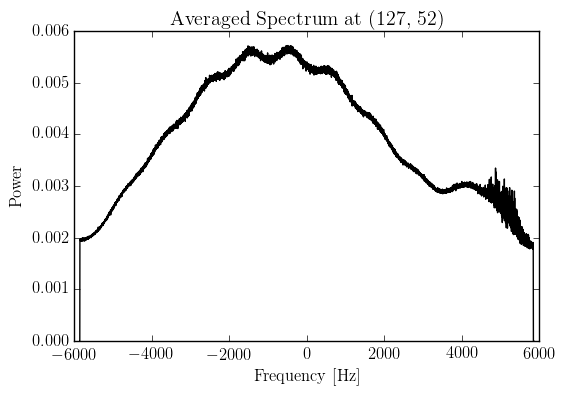

In [76]:
data = avg_spectrum(pyfits.open('data_new_90073.549594049_85.7715124491.fits'))
data_ = data[2]

freq = np.fft.fftfreq(len(data_), t)
plt.plot(freq[len(freq)/2:], data_[:len(data_)/2], 'k')
plt.plot(freq[:len(freq)/2], data_[len(data_)/2:], 'k')
plt.title('Averaged Power Spectrum at (127, 52)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.show()

In [77]:
ra = 73.54959404903836
dec = 85.77151244913685       
jd = 2458611.167002315
epoch_time = 1557244829.364249
doppler.get_projected_velocity(ra, dec, jd, obs_lat=leo.lat, obs_lon=leo.lon, obs_alt=leo.alt, epoch=epoch_time)

array([-9034.25992464])

Select a frequency range and convert to velocity range...

In [5]:
def velocity(freq):
    delta_freq = freq/1000 - 4.73
    v = - (delta_freq)/ (4.73) #km/s
    return v

In [6]:
def column_density(T_b, freq1, freq2):
    
    int_time = 0.6990506666666667
    samples = 8192
    t = int_time/samples
    
    freq = np.fft.fftfreq(len(T_b), t)
    delta_v = velocity(freq1) - velocity(freq2)
    
    index1 = np.min(np.where(freq > freq1))
    index2 = np.max(np.where(freq < freq2))
    
    N = 1.8e18 * T_b[index1:index2] * delta_v # cm-2
    avg_N = sum(N)/len(N)
    return avg_N

In [136]:
x = avg_spectrum(pyfits.open('data_new_90073.549594049_85.7715124491.fits'))
x_ = np.array(x[2]/gain_900[0])

column_density(x_, 4000., 4200.)

6.251854646196066e+18

## Making Maps

### Old Data

In [7]:
gain = 5.7936986306812226e-05

In [8]:
data1 = [[avg_spectrum(pyfits.open(f))[0] for f in glob.glob('data_date*.fits')],
        [avg_spectrum(pyfits.open(f))[1] for f in glob.glob('data_date*.fits')],
        [avg_spectrum(pyfits.open(f))[2] for f in glob.glob('data_date*.fits')]]

In [9]:
data2 = [[avg_spectrum(pyfits.open(f))[0] for f in glob.glob('data_may6*.fits')],
        [avg_spectrum(pyfits.open(f))[1] for f in glob.glob('data_may6*.fits')],
        [avg_spectrum(pyfits.open(f))[2] for f in glob.glob('data_may6*.fits')]]

In [10]:
data3 = [[avg_spectrum(pyfits.open(f))[0] for f in glob.glob('data_apr25*.fits')],
        [avg_spectrum(pyfits.open(f))[1] for f in glob.glob('data_apr25*.fits')],
        [avg_spectrum(pyfits.open(f))[2] for f in glob.glob('data_apr25*.fits')]]

In [11]:
l = [data1[0], data2[0], data3[0]]
longitude = np.array(list(chain.from_iterable(l)))

b = [data1[1], data2[1], data3[1]]
latitude = np.array(list(chain.from_iterable(b)))

all_data = []

for i in range(len(data1[2])):
    all_data.append(data1[2][i])
    
for i in range(len(data2[2])):
    all_data.append(data2[2][i]) 
    
for i in range(len(data3[2])):
    all_data.append(data3[2][i]) 

data = [longitude, latitude, all_data]

In [130]:
np.shape(all_data)

(473, 8192)

In [12]:
avg_data = []

for i in range(len(data[2])):
    avg = sum(data[2][i]) / len(data[2][i])
    avg_data.append(avg/gain)

In [13]:
missing_l = [119, 121, 121, 121, 121, 123, 123, 123, 123, 125, 125, 125, 127]
l_ = [data[0], missing_l]
longitude = np.array(list(chain.from_iterable(l_)))

missing_b = [ 27, 23, 25,  27,  29,  25,  27,  29,  31,  25,  27,  29,  27]
b_ = [data[1], missing_b]
latitude = np.array(list(chain.from_iterable(b_)))

missing_data = np.empty(((len(missing_l))))
missing_data[:] = np.nan
d_ = [avg_data, missing_data]
data_ = np.array(list(chain.from_iterable(d_)))

In [14]:
sorted_indices = np.argsort(longitude) # sorted longitude indices

sorted_data = [[], [], []] # sorted data based on longitude

for i in range(len(sorted_indices)):
    sorted_data[0].append(longitude[sorted_indices[i]])
    sorted_data[1].append(latitude[sorted_indices[i]])
    sorted_data[2].append(data_[sorted_indices[i]])

In [15]:
data_mod = [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
# avg power grouped by latitude, ordered by longitude

for k in range(18):
    for i in range(len(sorted_data[1])):
        if sorted_data[1][i] > (14 + 2*k) and sorted_data[1][i] < (16 + 2*k):
            data_mod[k].append(sorted_data[2][i])

In [16]:
for i in range(len(data_mod)):
    while len(data_mod[i]) < 28:
        data_mod[i].append(np.nan)

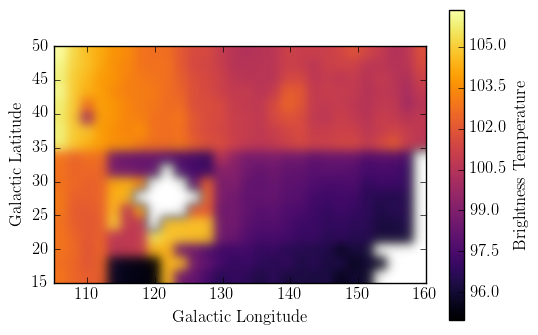

In [216]:
plt.figure()
plt.imshow(np.array(data_mod), cmap='inferno', interpolation='gaussian', aspect='equal', extent=[105,160,15,50], origin='lower')
cbar = plt.colorbar()
cbar.set_label('Brightness Temperature')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
plt.show()

In [17]:
coord = []

for i in range(len(sorted_data[0])):
    lon = sorted_data[0][i]
    lat = sorted_data[1][i]
    coord.append([lon, lat])

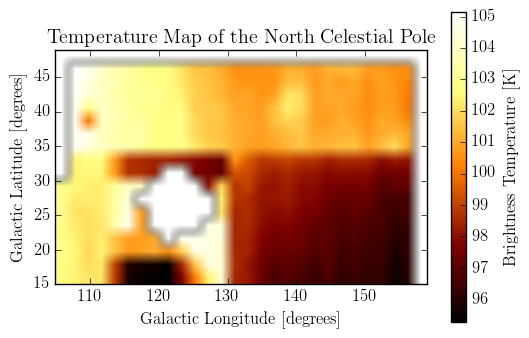

In [18]:
grid_x, grid_y = np.mgrid[105:159:28j, 15:49:18j]

grid_z = griddata(coord, sorted_data[2], (grid_x, grid_y))

plt.subplot(111)
plt.imshow(grid_z.T, cmap='afmhot',extent=(105,159,15,49), origin='lower')
cbar = plt.colorbar()
cbar.set_label('Brightness Temperature [K]')
plt.title('Temperature Map of the North Celestial Pole')
plt.xlabel('Galactic Longitude [degrees]')
plt.ylabel('Galactic Latitude [degrees]')
plt.show()

### New Data

In [19]:
def gain(noise_on, noise_off):
    diff = noise_on[2] - noise_off[2]
    gain = diff/30
    std = np.std(gain)
    avg_gain = sum(gain)/len(gain)
    return avg_gain, std

In [20]:
cal_100 = [avg_spectrum(pyfits.open(f)) for f in glob.glob('noise*100.fits')]
cal_300 = [avg_spectrum(pyfits.open(f)) for f in glob.glob('noise*300.fits')]
cal_600 = [avg_spectrum(pyfits.open(f)) for f in glob.glob('noise*_600.fits')]
cal_900 = [avg_spectrum(pyfits.open(f)) for f in glob.glob('noise*900.fits')]
cal_1000 = [avg_spectrum(pyfits.open(f)) for f in glob.glob('noise*1000.fits')]
cal_1100 = [avg_spectrum(pyfits.open(f)) for f in glob.glob('noise*1100.fits')]
cal_1200 = [avg_spectrum(pyfits.open(f)) for f in glob.glob('noise*1200.fits')]
cal_1300 = [avg_spectrum(pyfits.open(f)) for f in glob.glob('noise*1300.fits')]
cal_1600 = [avg_spectrum(pyfits.open(f)) for f in glob.glob('noise*1600.fits')]
cal_1630 = [avg_spectrum(pyfits.open(f)) for f in glob.glob('noise*1630.fits')]
cal_1930 = [avg_spectrum(pyfits.open(f)) for f in glob.glob('noise*1930.fits')]
cal_1955 = [avg_spectrum(pyfits.open(f)) for f in glob.glob('noise*1955.fits')]
cal_2200 = [avg_spectrum(pyfits.open(f)) for f in glob.glob('noise*2200.fits')]

In [21]:
# note: gain[0] = gain, gain[1] = std

gain_100 = gain(cal_100[1], cal_100[0])
gain_300 = gain(cal_300[1], cal_300[0])
gain_600 = gain(cal_600[1], cal_600[0])
gain_900 = gain(cal_900[1], cal_900[0])
gain_1000 = gain(cal_1000[1], cal_1000[0])
gain_1100 = gain(cal_1100[1], cal_1100[0])
gain_1200 = gain(cal_1200[1], cal_1200[0])
gain_1300 = gain(cal_1300[1], cal_1300[0])
gain_1600 = gain(cal_1600[1], cal_1600[0])
gain_1630 = gain(cal_1630[1], cal_1630[0])
gain_1930 = gain(cal_1930[1], cal_1930[0])
gain_1955 = gain(cal_1955[1], cal_1955[0])
gain_2200 = gain(cal_2200[1], cal_2200[0])

In [22]:
print 'STD at 1:00:', gain_100[1]
print 'STD at 3:00:', gain_300[1]
print 'STD at 6:00:', gain_600[1]
print 'STD at 9:00:', gain_900[1]
print 'STD at 10:00:', gain_1000[1]
print 'STD at 11:00:', gain_1100[1]
print 'STD at 12:00:', gain_1200[1]
print 'STD at 13:00:', gain_1300[1]
print 'STD at 16:00:', gain_1600[1]
print 'STD at 16:30:', gain_1630[1]
print 'STD at 19:30:', gain_1930[1]
print 'STD at 19:55:', gain_1955[1]
print 'STD at 22:00:', gain_2200[1]

STD at 1:00: 1.1371173007589183e-05
STD at 3:00: 2.709811690715441e-05
STD at 6:00: 2.3470757366145534e-05
STD at 9:00: 2.5374325776483048e-05
STD at 10:00: 2.484264445630129e-05
STD at 11:00: 2.1727982575156618e-05
STD at 12:00: 2.3253907188511194e-05
STD at 13:00: 2.396236383366735e-05
STD at 16:00: 2.2376078468483942e-05
STD at 16:30: 2.1350359991010624e-05
STD at 19:30: 2.634591479761611e-05
STD at 19:55: 2.599274970448904e-05
STD at 22:00: 2.62958239496105e-05


Greatest STD: 2.709811690715441e-05

In [23]:
data_100 = [[avg_spectrum(pyfits.open(f))[0] for f in glob.glob('data_new_0100*.fits')],
            [avg_spectrum(pyfits.open(f))[1] for f in glob.glob('data_new_0100*.fits')],
            [avg_spectrum(pyfits.open(f))[2] for f in glob.glob('data_new_0100*.fits')]/gain_100[0]]

data_300 = [[avg_spectrum(pyfits.open(f))[0] for f in glob.glob('data_new_300*.fits')],
            [avg_spectrum(pyfits.open(f))[1] for f in glob.glob('data_new_300*.fits')],
            [avg_spectrum(pyfits.open(f))[2] for f in glob.glob('data_new_300*.fits')]/gain_300[0]]

data_600 = [[avg_spectrum(pyfits.open(f))[0] for f in glob.glob('data_new_600*.fits')],
            [avg_spectrum(pyfits.open(f))[1] for f in glob.glob('data_new_600*.fits')],
            [avg_spectrum(pyfits.open(f))[2] for f in glob.glob('data_new_600*.fits')]/gain_600[0]]

data_900 = [[avg_spectrum(pyfits.open(f))[0] for f in glob.glob('data_new_900*.fits')],
            [avg_spectrum(pyfits.open(f))[1] for f in glob.glob('data_new_900*.fits')],
            [avg_spectrum(pyfits.open(f))[2] for f in glob.glob('data_new_900*.fits')]/gain_900[0]]

data_1000 = [[avg_spectrum(pyfits.open(f))[0] for f in glob.glob('data_new_1000*.fits')],
            [avg_spectrum(pyfits.open(f))[1] for f in glob.glob('data_new_1000*.fits')],
            [avg_spectrum(pyfits.open(f))[2] for f in glob.glob('data_new_1000*.fits')]/gain_1000[0]]

data_1100 = [[avg_spectrum(pyfits.open(f))[0] for f in glob.glob('data_new_1100*.fits')],
            [avg_spectrum(pyfits.open(f))[1] for f in glob.glob('data_new_1100*.fits')],
            [avg_spectrum(pyfits.open(f))[2] for f in glob.glob('data_new_1100*.fits')]/gain_1100[0]]

data_1200 = [[avg_spectrum(pyfits.open(f))[0] for f in glob.glob('data_new_1200*.fits')],
            [avg_spectrum(pyfits.open(f))[1] for f in glob.glob('data_new_1200*.fits')],
            [avg_spectrum(pyfits.open(f))[2] for f in glob.glob('data_new_1200*.fits')]/gain_1200[0]]

data_1300 = [[avg_spectrum(pyfits.open(f))[0] for f in glob.glob('data_new_1300*.fits')],
            [avg_spectrum(pyfits.open(f))[1] for f in glob.glob('data_new_1300*.fits')],
            [avg_spectrum(pyfits.open(f))[2] for f in glob.glob('data_new_1300*.fits')]/gain_1300[0]]

data_1600 = [[avg_spectrum(pyfits.open(f))[0] for f in glob.glob('data_new_1600*.fits')],
            [avg_spectrum(pyfits.open(f))[1] for f in glob.glob('data_new_1600*.fits')],
            [avg_spectrum(pyfits.open(f))[2] for f in glob.glob('data_new_1600*.fits')]/gain_1600[0]]

data_1630 = [[avg_spectrum(pyfits.open(f))[0] for f in glob.glob('data_new_1630*.fits')],
            [avg_spectrum(pyfits.open(f))[1] for f in glob.glob('data_new_1630*.fits')],
            [avg_spectrum(pyfits.open(f))[2] for f in glob.glob('data_new_1630*.fits')]/gain_1630[0]]

data_1930 = [[avg_spectrum(pyfits.open(f))[0] for f in glob.glob('data_new_1930*.fits')],
            [avg_spectrum(pyfits.open(f))[1] for f in glob.glob('data_new_1930*.fits')],
            [avg_spectrum(pyfits.open(f))[2] for f in glob.glob('data_new_1930*.fits')]/gain_1930[0]]

data_1955 = [[avg_spectrum(pyfits.open(f))[0] for f in glob.glob('data_new_1955*.fits')],
            [avg_spectrum(pyfits.open(f))[1] for f in glob.glob('data_new_1955*.fits')],
            [avg_spectrum(pyfits.open(f))[2] for f in glob.glob('data_new_1955*.fits')]/gain_1955[0]]

data_2200 = [[avg_spectrum(pyfits.open(f))[0] for f in glob.glob('data_new_2200*.fits')],
            [avg_spectrum(pyfits.open(f))[1] for f in glob.glob('data_new_2200*.fits')],
            [avg_spectrum(pyfits.open(f))[2] for f in glob.glob('data_new_2200*.fits')]/gain_2200[0]]

In [24]:
l = [data_100[0], data_300[0], data_900[0], data_1000[0], data_1200[0], data_1300[0], data_1600[0], data_1630[0], data_1930[0], data_1955[0], data_2200[0]]
longitude = np.array(list(chain.from_iterable(l)))

b = [data_100[1], data_300[1], data_900[1], data_1000[1], data_1200[1], data_1300[1], data_1600[1], data_1630[1], data_1930[1], data_1955[1], data_2200[1]]
latitude = np.array(list(chain.from_iterable(b)))

all_data = []

for i in range(len(data_100[2])):
    all_data.append(data_100[2][i])
    
for i in range(len(data_300[2])):
    all_data.append(data_300[2][i]) 
    
for i in range(len(data_600[2])):
    all_data.append(data_600[2][i]) 
    
for i in range(len(data_900[2])):
    all_data.append(data_900[2][i]) 
    
for i in range(len(data_1000[2])):
    all_data.append(data_1000[2][i]) 
    
for i in range(len(data_1100[2])):
    all_data.append(data_1100[2][i]) 
    
for i in range(len(data_1200[2])):
    all_data.append(data_1200[2][i]) 
    
for i in range(len(data_1300[2])):
    all_data.append(data_1300[2][i]) 
    
for i in range(len(data_1600[2])):
    all_data.append(data_1600[2][i]) 
    
for i in range(len(data_1630[2])):
    all_data.append(data_1630[2][i]) 
    
for i in range(len(data_1930[2])):
    all_data.append(data_1930[2][i]) 
    
for i in range(len(data_1955[2])):
    all_data.append(data_1955[2][i]) 
    
for i in range(len(data_2200[2])):
    all_data.append(data_2200[2][i]) 

data = [longitude, latitude, all_data]

In [25]:
np.shape(all_data)

(475, 8192)

In [26]:
avg_data = []

for i in range(len(data[2])):
    avg = sum(data[2][i]) / len(data[2][i])
    avg_data.append(avg)

In [27]:
missing_l = [119, 119, 121, 121, 121, 121, 123, 123, 123, 123, 125, 125, 125, 127]
l_ = [data[0], missing_l]
longitude = np.array(list(chain.from_iterable(l_)))

missing_b = [ 27,  29,  23,  25,  27,  29,  25,  27,  29,  31,  25,  27,  29,  27]
b_ = [data[1], missing_b]
latitude = np.array(list(chain.from_iterable(b_)))

missing_data = np.empty(((len(missing_l))))
missing_data[:] = np.nan
d_ = [avg_data, missing_data]
data_ = np.array(list(chain.from_iterable(d_)))

In [28]:
sorted_indices = np.argsort(longitude) # sorted longitude indices

sorted_data = [[], [], []] # sorted data based on longitude

for i in range(len(sorted_indices)):
    sorted_data[0].append(longitude[sorted_indices[i]])
    sorted_data[1].append(latitude[sorted_indices[i]])
    sorted_data[2].append(data_[sorted_indices[i]])

data_mod = [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
#avg power grouped by latitude, ordered by longitude

for k in range(18):
    for i in range(len(sorted_data[1])):
        if sorted_data[1][i] > (14 + 2*k) and sorted_data[1][i] < (16 + 2*k):
            data_mod[k].append(sorted_data[2][i])

for i in range(len(data_mod)):
    while len(data_mod[i]) < 28:
        data_mod[i].append(np.nan)

In [29]:
coord = []

for i in range(len(sorted_data[0])):
    lon = sorted_data[0][i]
    lat = sorted_data[1][i]
    coord.append([lon, lat])

missing = [[121, 21], [123, 21], [123, 23], [125, 21], [125, 23], [127, 17], [127, 19], [127, 21], [127, 23], [129, 15], [129, 17], [129, 19], [129, 21], [129, 23], [129, 25], [129, 27], [129, 29]]

for i in range(len(missing)):
    coord.append(missing[i])
    sorted_data[2].append(np.nan)

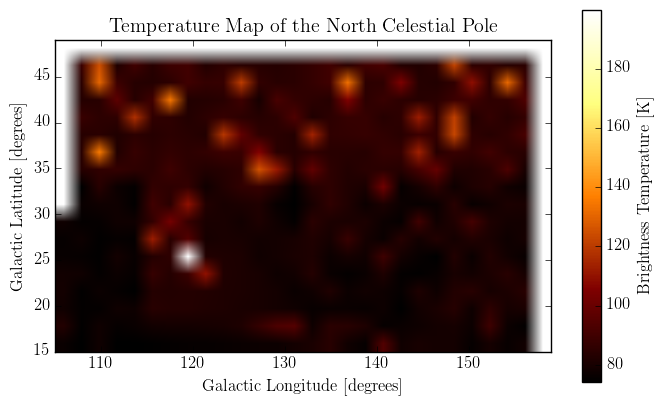

In [32]:
grid_x, grid_y = np.mgrid[105:159:28j, 15:49:18j]

grid_z = griddata(coord, np.absolute(sorted_data[2]), (grid_x, grid_y))

plt.figure(figsize=(8,8))
plt.subplot(111)
plt.imshow(grid_z.T, cmap='afmhot', aspect='equal', extent=(105,159,15,49), origin='lower')
tix = [80, 100, 120, 140, 160, 180, 200]
cbar = plt.colorbar(shrink = 0.6, ticks=tix)
cbar.set_label('Brightness Temperature [K]')
plt.title('Temperature Map of the North Celestial Pole')
plt.xlabel('Galactic Longitude [degrees]')
plt.ylabel('Galactic Latitude [degrees]')
plt.show()

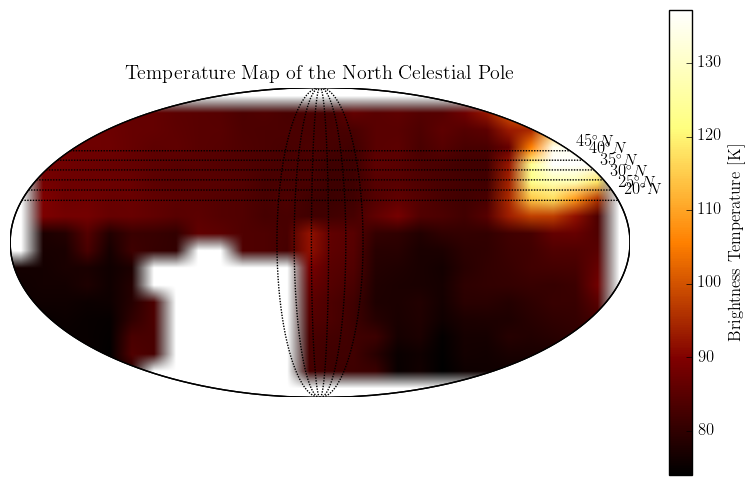

In [131]:
from mpl_toolkits.basemap import Basemap

m = Basemap(projection='moll', lon_0=130) # Mollweide projection
grid_x, grid_y = np.mgrid[105:159:28j, 15:49:18j]
grid_z = griddata(coord, np.absolute(sorted_data[2]), (grid_x, grid_y))

lt = grid_y[:,0]
ln1 = np.ones_like(lt) * (grid_x[grid_x.shape[0]/2,0])
ln2 = np.ones_like(lt) * (grid_x[grid_x.shape[0]/2,-1])
x1,y1 = m(ln1,lt); x2,y2 = m(ln2,lt)
x = np.arange(0,504)
x = np.ma.array(x)
for c,(i,j) in enumerate(zip(x1,x2)): x[c] = np.ma.masked_outside(x[c], i, j)
mask = x.mask

plt.figure(figsize=(10,10))
plt.subplot(111)
m.imshow(np.ma.array(grid_z.T, mask=mask), cmap='afmhot')
tix = [80, 90, 100, 110, 120, 130]
cbar = plt.colorbar(shrink = 0.6, ticks=tix)
cbar.set_label('Brightness Temperature [K]')
plt.title('Temperature Map of the North Celestial Pole')
m.drawmapboundary()
m.drawmeridians(np.arange(105, 160, 10)) # longitude range
m.drawparallels(np.arange(15, 50, 5)[1:], labels=[0,1,0,0]) # latitude range
plt.show()

In [ ]:
avg_data = []

for i in range(len(data[2])):
    avg = sum(data[2][i]) / len(data[2][i])
    avg_data.append(avg)
    
missing_l = [119, 119, 121, 121, 121, 121, 123, 123, 123, 123, 125, 125, 125, 127]
l_ = [data[0], missing_l]
longitude = np.array(list(chain.from_iterable(l_)))

missing_b = [ 27,  29,  23,  25,  27,  29,  25,  27,  29,  31,  25,  27,  29,  27]
b_ = [data[1], missing_b]
latitude = np.array(list(chain.from_iterable(b_)))

missing_data = np.empty(((len(missing_l))))
missing_data[:] = np.nan
d_ = [avg_data, missing_data]
data_ = np.array(list(chain.from_iterable(d_)))

sorted_indices = np.argsort(longitude) # sorted longitude indices

sorted_data = [[], [], []] # sorted data based on longitude

for i in range(len(sorted_indices)):
    sorted_data[0].append(longitude[sorted_indices[i]])
    sorted_data[1].append(latitude[sorted_indices[i]])
    sorted_data[2].append(data_[sorted_indices[i]])
    
coord = []

for i in range(len(sorted_data[0])):
    lon = sorted_data[0][i]
    lat = sorted_data[1][i]
    coord.append([lon, lat])
    
missing = [[121, 21], [123, 21], [123, 23], [125, 21], [125, 23], [127, 17], [127, 19], [127, 21], [127, 23], [129, 15], [129, 17], [129, 19], [129, 21], [129, 23], [129, 25], [129, 27], [129, 29]]

for i in range(len(missing)):
    coord.append(missing[i])
    sorted_data[2].append(np.nan)

In [ ]:
grid_x, grid_y = np.mgrid[105:159:28j, 15:49:18j]

grid_z = griddata(coord, np.absolute(sorted_data[2]), (grid_x, grid_y))

plt.figure(figsize=(8,8))
plt.subplot(111)
plt.imshow(grid_z.T, cmap='afmhot', aspect='equal', extent=(105,159,15,49), origin='lower')
tix = [80, 90, 100, 110, 120, 130]
cbar = plt.colorbar(shrink = 0.6, ticks=tix)
cbar.set_label('Column Density [$cm^-2$]')
plt.title('H Column Density in Velocity Range')
plt.xlabel('Galactic Longitude [degrees]')
plt.ylabel('Galactic Latitude [degrees]')
plt.show()